<h1> Gaussian Mixture Model on Cars Dataset </h1>

In [31]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from matplotlib import colors
import matplotlib
import pylab as pl
import pandas as pd
%matplotlib inline

<h1> Cleaning the data to replace NA fields with zeroes </h1>


In [32]:
## Cleaning the data to fill replace NA fields with zeroes
data = pd.read_csv('cars.csv')
data = data.fillna(0)
data.brand = pd.Categorical(data.brand)
## converting the string brand into a categorical variable
data['brand_categorical_variable'] = data.brand.cat.codes


In [33]:
features_to_be_included = ['mpg', 'cylinders', 'cubicinches', 'hp', 'weightlbs', 'time-to-60', 'year' ,'brand_categorical_variable' ]
data = data[features_to_be_included]
data[:2]
print ("Total number of records in dataset:",len(data))


Total number of records in dataset: 261


<h1>** Code referred from professor reading assignment links **

</h1>

In [34]:
from matplotlib.patches import Ellipse
import numpy as np
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)


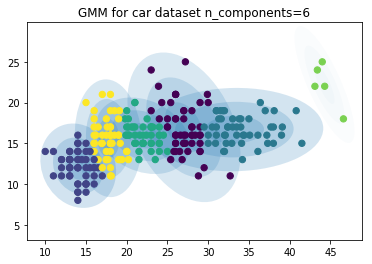

In [35]:
number_of_components=6
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=number_of_components,covariance_type='full',verbose=0,verbose_interval=10,max_iter=5000).fit(data.values)
labels = gmm.predict(data.values)
test_features= ['mpg','time-to-60']
X = data[test_features].values
plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis');
plt.title("GMM for car dataset n_components=6")
plot_gmm(gmm,X)

<h1> ** Identifying optimal number of n components using AIC/ BIC criteria**</h1>

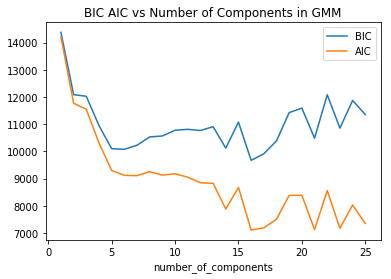

In [36]:
gmm_models = [GaussianMixture(n_components=i,
                              covariance_type='full',max_iter=500).fit(data.values) 
              for i in range(1,26)] 
n_components = [i for i in range(1,26)]
plt.plot(n_components, [m.bic(data.values) for m in gmm_models], label='BIC')
plt.plot(n_components, [m.aic(data.values) for m in gmm_models], label='AIC')
plt.title("BIC AIC vs Number of Components in GMM")
plt.legend(loc='best')
plt.xlabel('number_of_components');

<h1> Density estimation and GMM Generator </h1>

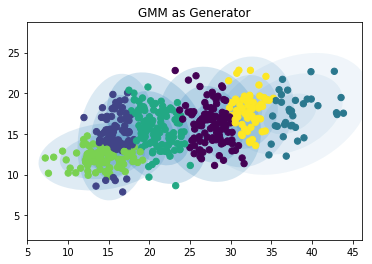

In [37]:
#density estimation using GMM as generator
gmm = GaussianMixture(n_components=number_of_components,covariance_type='full', random_state=0)
model = gmm.fit(data.values)
(genX, genY) = model.sample(500)
plt.scatter(genX[:,0], genX[:,5],c=genY,s=10,cmap='viridis')
test_features= ['mpg','time-to-60']
X = data[test_features].values
plt.title("GMM as Generator")
genX = genX[:,[0,5]]
plot_gmm(gmm,genX)


<h1> Hierarchial Clustering using AgglomerativeClustering </h1>

Text(0,0.5,'weight in pounds')

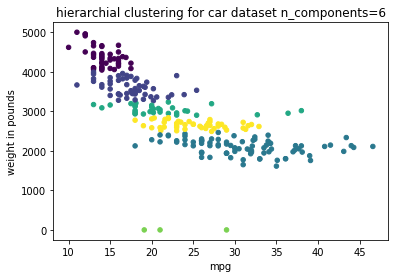

In [38]:
## TBD
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import FeatureAgglomeration
from sklearn.neighbors import kneighbors_graph
KeepXNearestPointsConnected = kneighbors_graph(data.values, n_neighbors=number_of_components, include_self=False)
HC = AgglomerativeClustering(n_clusters=number_of_components, linkage='ward', connectivity=KeepXNearestPointsConnected)
HC.fit(data.values)
test_features= ['mpg','weightlbs']
X = data[test_features].values
plt.scatter(X[:, 0], X[:, 1], c=HC.labels_, s=20, cmap='viridis');
plt.title("hierarchial clustering for car dataset n_components=6")
plt.xlabel("mpg")
plt.ylabel("weight in pounds")
#plot_hierarchial_clustering(ward,X)

<h1> Evaluation of Hierarchial Clustering </h1>

In [39]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
X = data.values
labels = HC.labels_
metrics.calinski_harabaz_score(X, labels)  

1097.90099504845

<h1> Comparing silhoutte score K means, GMM, Hierarchial Clustering for 6 components </h1>

In [40]:
from sklearn.metrics import silhouette_score
silhoutte_coefficients = []
gmm = GaussianMixture(n_components=number_of_components,covariance_type='spherical',verbose=0,verbose_interval=10,max_iter=5000).fit(data.values)
gmm_labels = gmm.predict(data.values)
gmm_silhoute_score = silhouette_score(data, gmm_labels, metric='euclidean')
kmeans = KMeans( init='k-means++',n_clusters=number_of_components)
kmeans_model = kmeans.fit(data)
kmeans_labels = kmeans_model.labels_
kmeans_silhoute_score = silhouette_score(data, kmeans_labels, metric='euclidean')
KeepXNearestPointsConnected = kneighbors_graph(data.values, n_neighbors=10, include_self=False)
HC = AgglomerativeClustering(n_clusters=number_of_components, linkage='ward', connectivity=KeepXNearestPointsConnected)
HC.fit(data.values)
HC_silhoute_score = silhouette_score(data, HC.labels_, metric='euclidean')
print ("Silhoutte score for Kmeans:",kmeans_silhoute_score, "GMM:", gmm_silhoute_score, "Hierarchial Clustering:",HC_silhoute_score)

Silhoutte score for Kmeans: 0.5577411582258999 GMM: 0.5540975273331654 Hierarchial Clustering: 0.5508020116840029


<h1> Comparing calinski_harabaz_score score K means, GMM, Hierarchial Clustering for 6 components </h1>

In [41]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
X = data.values
HC_ch_score = metrics.calinski_harabaz_score(X, HC.labels_)  
kmeans_ch_score = metrics.calinski_harabaz_score(X,kmeans_model.labels_)
gmm_ch_score = metrics.calinski_harabaz_score(X, gmm_labels)
print ("Calinski Harabaz score: ", "kmeans:",kmeans_ch_score,  "gmm:",gmm_ch_score, "Hierarchial Clustering:",HC_ch_score)

Calinski Harabaz score:  kmeans: 1180.6786156464161 gmm: 1116.1574935092121 Hierarchial Clustering: 1097.90099504845
